In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [3]:
import tensorflow as tf
from tensorflow.keras import models,layers
import matplotlib.pyplot as plt

In [45]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS =3
EPOCHS =20


In [46]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
   "/kaggle/input/cat-and-dog/training_set/training_set",
   shuffle =True,
   image_size =(IMAGE_SIZE,IMAGE_SIZE),
   batch_size= BATCH_SIZE
)

Found 8005 files belonging to 2 classes.


In [47]:
class_names = dataset.class_names

In [48]:
class_names

['cats', 'dogs']

In [49]:
len(dataset)

251

In [50]:
for image_batch, label_batch in dataset.take(1):
  print(image_batch[1].shape)
  print(label_batch[0].numpy())

(256, 256, 3)
0


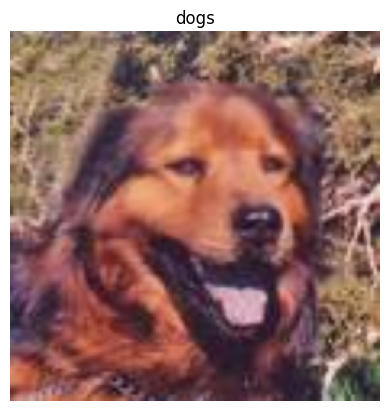

In [51]:
for image_batch, label_batch in dataset.take(1):

 plt.imshow(image_batch[1].numpy().astype("uint8"))
 plt.title(class_names[label_batch[1]])
 plt.axis('off')

In [52]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split =0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
  ds_size=len(ds)

  if shuffle:
    ds=ds.shuffle(shuffle_size, seed=12)

  train_size= int(train_split * ds_size)
  # print(train_size)
  val_size =int(val_split * ds_size)

  train_ds =ds.take(train_size)
  # print(len(train_ds))

  val_ds =ds.skip(train_size).take(val_size)
  test_ds = ds.skip(train_size).skip(val_size)
  return train_ds, val_ds, test_ds

In [53]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [54]:
len(train_ds)

200

In [55]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [56]:
resize_rescale=tf.keras.Sequential(
    [
        layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
        layers.experimental.preprocessing.Rescaling(1.0/255)
    ]
)

In [57]:
data_agumentation=tf.keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
        layers.experimental.preprocessing.RandomRotation(0.2)
    ]
)

In [58]:
# convonutional neural network
n_classes = 2
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
model = models.Sequential(
    [
        resize_rescale,
        data_agumentation,
        layers.Conv2D(32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Conv2D(64,(3,3),activation='relu'),
        layers.MaxPooling2D((2,2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(n_classes, activation = 'softmax')

    ]
)
model.build(input_shape=input_shape)

In [59]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 conv2d_9 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [60]:
model.compile(
    optimizer ='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose =1,
    validation_data = val_ds
)

Epoch 1/20
106/200 [==============>...............] - ETA: 4:07 - loss: 0.6940 - accuracy: 0.5224

In [ ]:
test_dataset=tf.keras.preprocessing.image_dataset_from_directory(
   "/kaggle/input/cat-and-dog/test_set/test_set",
   shuffle =True,
   image_size =(IMAGE_SIZE,IMAGE_SIZE),
   batch_size= BATCH_SIZE
)